The purpose of this file is to calculate RSCU values for codons in a given sequence, optionally using a sliding window approach and considering cleavage sites. It includes functionality to visualize the RSCU values and filter them based on variance thresholds.

In [26]:
import sys
import os

# Add the directory containing your modules to Python path
sys.path.append('/Users/ellateasell/Research/CodonUsageBias/code')

In [27]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from rscu_methods import extract_window, ensure_valid_orf, calculate_rscu, rscu_to_string, extract_window_and_complement, extract_SP_and_complement
from rscu import PROJ_DIR 
import pandas as pd
import numpy as np
from lib.aminoacids import AA_TO_CODONS_MULTI_CODON_FAMILIES

In [29]:
def run_rscu_analysis(records: list[SeqRecord], df: pd.DataFrame, w_n, d_n, csUsed, SP = False):
    if csUsed:
        print(f"Using cleavage site with window size {w_n} in nucelotides and distance {d_n} in nucelotides from CS")
    else:
        print(f"Not using cleavage site with window size {w_n} in nucleotides and distance {d_n} in nucleotides from start")
        

    full_orfs = []
    windows = []

    # for each record in fasta, extract ROI and full and concatenate with the rest of the ORFs
    for record in records: # record is SeqRecord object
        
        #find corresponding row in tsv file
        row = df.loc[record.id]
        
        # extract cleavage site
        # note that from this data file, the cleavage site corresponds to the amino acid position
        cs_aa = row['cs']
        # cs_n is the position of the cleavage site within the nucleotide sequence
        cs_n = int(cs_aa * 3)
        
        # extract window and complement
        if SP:
            extraction = extract_SP_and_complement(record, cs_n)
        else:
            if not csUsed: cs_n = 0
            extraction = extract_window_and_complement(record, w_n, d_n, cs_n)
        if extraction is not None:
            window_str, comeplement_str = extraction
        else:
            print(f"Invalid extraction for record {record.id}. Skipping.")
            continue
        valid_window, codons_window = ensure_valid_orf(window_str)
        valid_comp, codons_comp = ensure_valid_orf(comeplement_str)
        
        # only accept valid windows and full ORFS
        if window_str is None or not valid_window or not valid_comp:
            print(f"Invalid ORF for record {record.id}: complement valid: {valid_comp}, window valid: {valid_window}")
            continue
        else:
            windows += codons_window
            full_orfs += codons_comp

    window_rscu = calculate_rscu(windows)
    full_rscu = calculate_rscu(full_orfs)
    
    return window_rscu, full_rscu

In [30]:
######### Using windows and complements

w_aa = 10  # window size in amino acids
d_aa = 0  # distance from cleavage site in amino acids
csUsed = True
SP = False

# adjust for nucleotides
w = int(w_aa*3) # window size in nucleotides
d = int(d_aa*3) # distance from cleavage site in nucleotides

# load SP ORFS (genomic)
all_fasta_path = PROJ_DIR / 'data/filtered/dna_filtered.fasta'
records = list(SeqIO.parse(all_fasta_path, 'fasta'))

# load SP data
tsv_path = PROJ_DIR / 'data/filtered/sp_regions_filtered.tsv'
df = pd.read_table(tsv_path, index_col='sys_name')

max_len = max(len(record.seq) for record in records)
min_len = min(len(record.seq) for record in records)
print(f"Min length of records: {min_len}")
print(f"Max length of records: {max_len}")
avg_len = np.mean([len(record.seq) for record in records])
print(f"Average length of records: {avg_len}")

max_cs = df['cs'].max()
min_cs = df['cs'].min()
print(f"Max cleavage site: {max_cs}")
print(f"Min cleavage site: {min_cs}")

window_rscu, full_rscu = run_rscu_analysis(records, df, w, d, csUsed, SP)

print("RSCU values for window:")
print(rscu_to_string(window_rscu))
print("RSCU values for complement ORF:")
print(rscu_to_string(full_rscu))
    

Min length of records: 240
Max length of records: 5409
Average length of records: 1373.0229357798164
Max cleavage site: 38.0
Min cleavage site: 16.0
Using cleavage site with window size 30 in nucelotides and distance 0 in nucelotides from CS
RSCU values for window:
GCT: 1.73
GCC: 0.72
GCA: 1.08
GCG: 0.46
CGT: 0.53
CGC: 0.13
CGA: 0.13
CGG: 0.13
AGA: 3.47
AGG: 1.60
AAT: 1.04
AAC: 0.96
GAT: 1.17
GAC: 0.83
TGT: 1.40
TGC: 0.60
CAA: 1.46
CAG: 0.54
GAA: 1.44
GAG: 0.56
GGT: 1.80
GGC: 1.07
GGA: 0.73
GGG: 0.39
CAT: 1.43
CAC: 0.57
ATT: 1.29
ATC: 0.77
ATA: 0.94
TTA: 1.52
TTG: 1.52
CTT: 0.72
CTC: 0.52
CTA: 1.28
CTG: 0.44
AAA: 0.93
AAG: 1.07
TTT: 1.07
TTC: 0.93
CCT: 1.15
CCC: 0.77
CCA: 1.67
CCG: 0.42
TCT: 1.55
TCC: 1.19
TCA: 1.36
TCG: 0.29
AGT: 0.88
AGC: 0.74
ACT: 1.37
ACC: 1.17
ACA: 1.03
ACG: 0.43
TAT: 1.18
TAC: 0.82
GTT: 1.30
GTC: 1.02
GTA: 0.76
GTG: 0.92
RSCU values for complement ORF:
GCT: 1.66
GCC: 0.99
GCA: 0.99
GCG: 0.36
CGT: 0.93
CGC: 0.36
CGA: 0.37
CGG: 0.27
AGA: 2.90
AGG: 1.16
AAT: 1.07
AA

In [31]:
# RSCU values to numpy arrays

rscu_w = np.array(list(window_rscu.values()))
rscu_b = np.array(list(full_rscu.values()))

codons = list(window_rscu.keys())

diffs = rscu_w - rscu_b
avg_diffs = np.mean(diffs)

ratios = rscu_w / rscu_b
avg_ratios = np.mean(ratios)

print(f"Average difference: {avg_diffs:.3f}")
print(f"Average ratio: {avg_ratios:.3f}")

print("Differences between window and full ORF RSCU values:")
for codon, diff in zip(codons, diffs): 
    if (diff > 0.1):
        print(f"{codon}: {diff:.3f}")

Average difference: -0.000
Average ratio: 0.990
Differences between window and full ORF RSCU values:
GCG: 0.101
AGA: 0.562
AGG: 0.442
GGC: 0.295
CAT: 0.205
ATA: 0.215
CTC: 0.141
CTA: 0.410
AAG: 0.209
CCC: 0.165
TCC: 0.120
TCA: 0.148
AGC: 0.158
ACC: 0.143
TAT: 0.164
GTG: 0.239


In [32]:
aa_codon_dict = {
    aa: {codon: 0 for codon in codons_lst}
    for aa, codons_lst in AA_TO_CODONS_MULTI_CODON_FAMILIES.items()
}

for i in range(len(codons)):
    codon = codons[i]
    diff = diffs[i]
    for aa, codons_lst in AA_TO_CODONS_MULTI_CODON_FAMILIES.items():
        if codon in codons_lst:
            aa_codon_dict[aa][codon] = diff
     
variances = {aa: np.var(list(codon_family.values())) for aa, codon_family in aa_codon_dict.items()}
print("Variance of differences by amino acid:")
for aa, var in variances.items():
    print(f"{aa}: {var:.3f}")
                
print("Differences by amino acid:")
for aa, codon_family in aa_codon_dict.items():
    print(f"{aa}:")
    for codon, diff in codon_family.items():
        print(f"  {codon}: {diff:.3f}")
    var = np.var(list(codon_family.values()))
    print(f"  Sum: {sum(codon_family.values()):.3f}")
    print(f"  Variance: {var:.3f}")
    
    
##### filter codon list for the scatterplot by family variance threshold
variance_threshold = 0.03
varied_aa = [aa for aa, var in variances.items() if var >= variance_threshold]
print(f"Amino acids with variance >= {variance_threshold}: {varied_aa}")

filtered_w = []
filtered_b = []
filtered_codons = []
for aa in varied_aa:
    for codon, diff in aa_codon_dict[aa].items():
        i = codons.index(codon)
        filtered_w.append(rscu_w[i])
        filtered_b.append(rscu_b[i])
        filtered_codons.append(codon)
        
filtered_b = np.array(filtered_b)
filtered_w = np.array(filtered_w)
print(filtered_codons)



Variance of differences by amino acid:
A: 0.025
R: 0.133
N: 0.001
D: 0.006
C: 0.004
Q: 0.003
E: 0.001
G: 0.031
H: 0.042
I: 0.023
L: 0.052
K: 0.044
F: 0.001
P: 0.019
S: 0.026
T: 0.009
Y: 0.027
V: 0.029
Differences by amino acid:
A:
  GCT: 0.072
  GCC: -0.272
  GCA: 0.099
  GCG: 0.101
  Sum: -0.000
  Variance: 0.025
R:
  CGT: -0.400
  CGC: -0.231
  CGA: -0.240
  CGG: -0.133
  AGA: 0.562
  AGG: 0.442
  Sum: 0.000
  Variance: 0.133
N:
  AAT: -0.038
  AAC: 0.038
  Sum: 0.000
  Variance: 0.001
D:
  GAT: -0.076
  GAC: 0.076
  Sum: -0.000
  Variance: 0.006
C:
  TGT: 0.060
  TGC: -0.060
  Sum: 0.000
  Variance: 0.004
Q:
  CAA: 0.053
  CAG: -0.053
  Sum: -0.000
  Variance: 0.003
E:
  GAA: 0.038
  GAG: -0.038
  Sum: -0.000
  Variance: 0.001
G:
  GGT: -0.164
  GGC: 0.295
  GGA: -0.093
  GGG: -0.038
  Sum: 0.000
  Variance: 0.031
H:
  CAT: 0.205
  CAC: -0.205
  Sum: 0.000
  Variance: 0.042
I:
  ATT: -0.118
  ATC: -0.097
  ATA: 0.215
  Sum: -0.000
  Variance: 0.023
L:
  TTA: -0.018
  TTG: -0.285
  C

In [33]:
SLOW = [
    'TCG',
    'CCG',
    'ACG',
    'GCG',
    'GGG',
    'ATA',
    'CTG',
    'CGA',
    'CGG',
    'GTG'
]

FAST = [
    'TCT',
    'TCC',
    'GCC',
    'GGT',
    'TTA',
    'TTG',
    'CGT',
    'GTT'
]

colours = ['k'] * len(codons)

for codon in SLOW:
    index = codons.index(codon)
    colours[index] = 'r' # slow codon
    
for codon in FAST:
    index = codons.index(codon)
    colours[index] = 'b'  # fast codon
    


filtered_colours = ['k'] * len(filtered_codons)

for codon in SLOW:
    if codon not in filtered_codons:
        continue
    index = filtered_codons.index(codon)
    filtered_colours[index] = 'r' # slow codon
    
for codon in FAST:
    if codon not in filtered_codons:
        continue
    index = filtered_codons.index(codon)
    filtered_colours[index] = 'b'  # fast codon

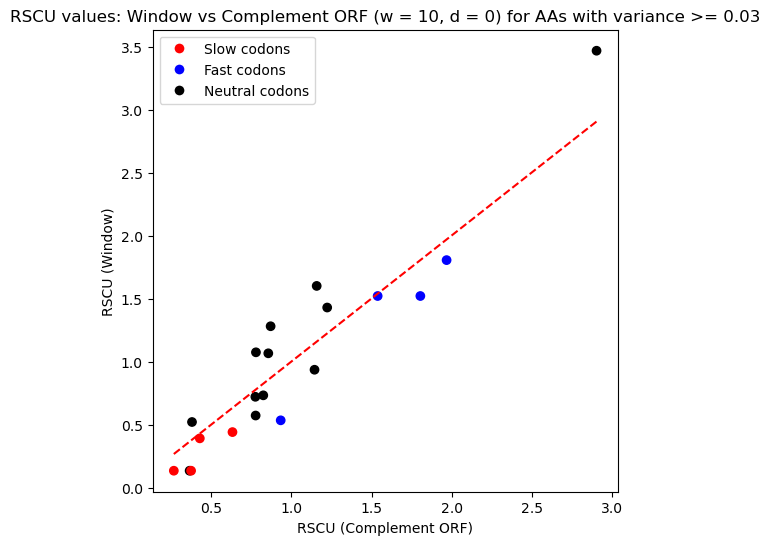

In [34]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 6))
plt.scatter(filtered_b, filtered_w, c = filtered_colours)
plt.xlabel('RSCU (Complement ORF)')
plt.ylabel('RSCU (Window)')
if SP is False:
    plt.title(f'RSCU values: Window vs Complement ORF (w = {w_aa}, d = {d_aa}) for AAs with variance >= {variance_threshold}')
else:   
    plt.title(f'RSCU values: SP vs Complement ORF for AAs with variance >= {variance_threshold}')
plt.plot([min(rscu_b), max(rscu_b)], [min(rscu_b), max(rscu_b)], 'r--')
# Create custom legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Slow codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Fast codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Neutral codons')]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()

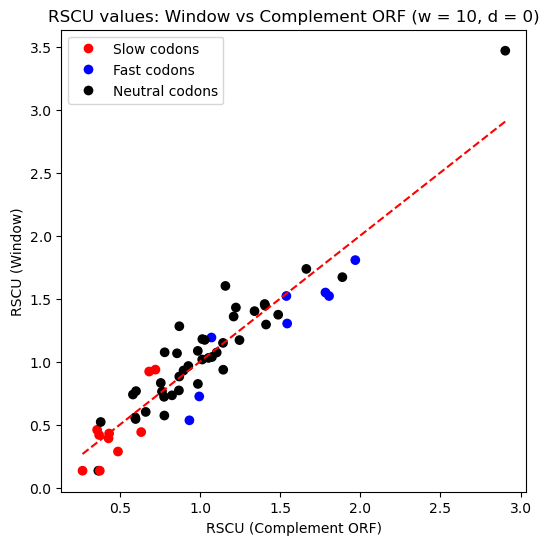

In [35]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 6))
plt.scatter(rscu_b, rscu_w, c = colours)
plt.xlabel('RSCU (Complement ORF)')
plt.ylabel('RSCU (Window)')
if SP is False:
    plt.title(f'RSCU values: Window vs Complement ORF (w = {w_aa}, d = {d_aa})')
else:   
    plt.title(f'RSCU values: SP vs Complement ORF')
plt.plot([min(rscu_b), max(rscu_b)], [min(rscu_b), max(rscu_b)], 'r--')
# Create custom legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Slow codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Fast codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Neutral codons')]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()